# EURO-LABS 2024: Advanced Training School on Operation of Accelerators
*T. Prebibaj, F. Asvesta

In [32]:
# Import xsuite modules and other libraries
import xtrack as xt
import xpart as xp
import xplt

from cpymad.madx import Madx
import numpy as np
import matplotlib.pyplot as plt

import NAFFlib
from scipy.signal import argrelextrema
from scipy.fftpack import fft


---

# Tracking with Xsuite

Tracking in a real accelerator lattice with the tracking code [Xsuite](https://xsuite.readthedocs.io/en/latest/).

---

### Exercise 5: reconstruct tune from turn-by-turn data

- Match the PSB lattice in the working point of $(Q_x, Q_y)=(4.403, 4.453)$  and track a single particle for 1000 turns. 

- Do an FFT analysis to calculate the tune from the turn-by-turn data (you can use scipy.fft or NAFFlib)

- Add some noise to the TbT beam position and re-do the FFT.

In [62]:
# The MAD-X sequence is at the psb/psb.seq file. The aperture of each element is defined at psb/psb_aperture.dbx
mad = Madx()
mad.options.echo = False # to not print the stdout of MAD-X  
mad.chdir('psb')
mad.call('psb_flat_bottom.madx') # loads the PSB sequence, aperture, etc. in MAD-X
line= xt.Line.from_madx_sequence(mad.sequence['psb1'],
                                 deferred_expressions=True,
                                 allow_thick=True)

# We need to add a reference particle for the twiss calculation (mass, energy)
line.particle_ref=xp.Particles(mass0=xp.PROTON_MASS_EV,gamma0=mad.sequence.psb1.beam.gamma)
print('Reference particle added at gamma0=%s.'%(mad.sequence.psb1.beam.gamma))

# Xsuite tracks in 3D, so we need to add a voltage to the RF cavity to simulate the longitudinal motion
line.element_refs['br.c02'].voltage = 0.008*1e6
print('Constant voltage = 8 kV added to the dummy RF.')

Qx0 = 4.403
Qy0 = 4.453
# Here we vary the strength of the quadrupoles (two knobs) to reach the target tunes (two constraints)
# The matching process is not always possible..
line.match(
      vary=[
            xt.Vary('kbrqf', step=1e-8),
            xt.Vary('kbrqd', step=1e-8),
      ],
      targets = [
                  xt.Target('qx', Qx0, tol=1e-5),
                  xt.Target('qy', Qy0, tol=1e-5)
      ]
)

twiss = line.twiss()
twiss_df = twiss.to_pandas()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2024.05.22 19:29:05      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
++++++ info: seqedit - number of elements installed:  1
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


Converting sequence "psb1":   0%|          | 0/530 [00:00<?, ?it/s]

Reference particle added at gamma0=1.1705262269290748.
Constant voltage = 8 kV added to the dummy RF.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Matching: model call n. 4       



In [63]:
# Built a set of three particles with different y coordinates
# (context and particle_ref are taken from the line)
particles = line.build_particles(x = [0.5e-3], y=[1e-3])

num_turns = 1000
line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)

x_tbt = line.record_last_track.x[0]
y_tbt = line.record_last_track.y[0]

Text(0, 0.5, 'Amplitude [mm]')

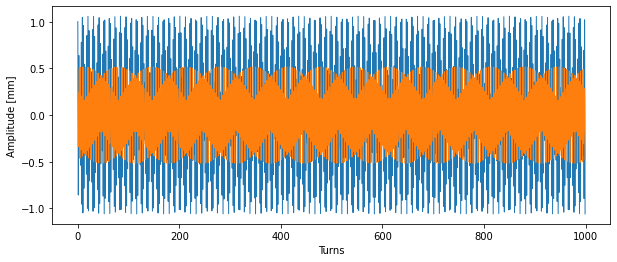

In [96]:
plt.figure(figsize=(10,4))
plt.plot(y_tbt*1e3, linewidth=1)
plt.plot(x_tbt*1e3, linewidth=1)
plt.xlabel('Turns')
plt.ylabel('Amplitude [mm]')

In [97]:
# spectrum using scipy
data = np.array(x_tbt)
N = len(data)
freqs = np.linspace(0,1,N)
ampls = fft(data)
tunes = freqs[:N//2]
norm_ampls = abs(ampls[:N//2])/np.max(abs(ampls))
maximas = argrelextrema(norm_ampls, np.greater)
inds = norm_ampls[maximas].argsort()
max_ampls = norm_ampls[maximas][inds][::-1]
max_tunes = tunes[maximas][inds][::-1]

# spectrum using NAFFlib
norder = 3 # number of the most dominant frequencies
qs, A, B = NAFFlib.get_tunes(data, norder)

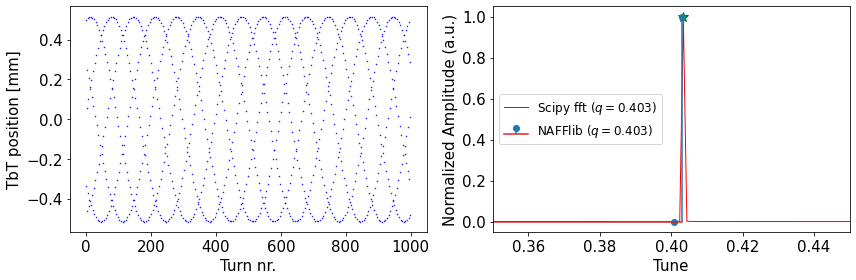

In [98]:
f,axs = plt.subplots(1,2,figsize=(12,4))
fontsize=15

ax = axs[0]
ax.set_xlabel('Turn nr.', fontsize=fontsize)
ax.set_ylabel('TbT position [mm]', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.plot(data*1e3, '.', ms=1.0, c='blue')

ax = axs[1]
ax.set_xlabel('Tune', fontsize=fontsize)
ax.set_ylabel('Normalized Amplitude (a.u.)', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.plot(tunes, norm_ampls, '-', c='red', lw=1.0, label='Scipy fft ($q=%1.3f$)'%max_tunes[0])
ax.plot(max_tunes[0:1], max_ampls[0:1], '*', ms=10, color='green')
ax.stem(qs, abs(A/np.max(A)), label='NAFFlib ($q=%1.3f$)'%qs[0])
ax.legend(loc=0, fontsize=fontsize-3)
ax.set_xlim(0.35,0.45)

f.tight_layout()
plt.show()


In [122]:
# Adding errors in the turn-by-turn data
data2 = data #+ 1e-3*np.random.randn(len(data)) # noise
data2 = 1.05*data2 # 5 percent calibration error to the turn-byt-turn data


# spectrum using scipy
N = len(data2)
freqs = np.linspace(0,1,N)
ampls = fft(data2)
tunes = freqs[:N//2]
norm_ampls = abs(ampls[:N//2])/np.max(abs(ampls))
maximas = argrelextrema(norm_ampls, np.greater)
inds = norm_ampls[maximas].argsort()
max_ampls = norm_ampls[maximas][inds][::-1]
max_tunes = tunes[maximas][inds][::-1]

# spectrum using NAFFlib
norder = 3 # number of the most dominant frequencies
qs, A, B = NAFFlib.get_tunes(data2, norder)

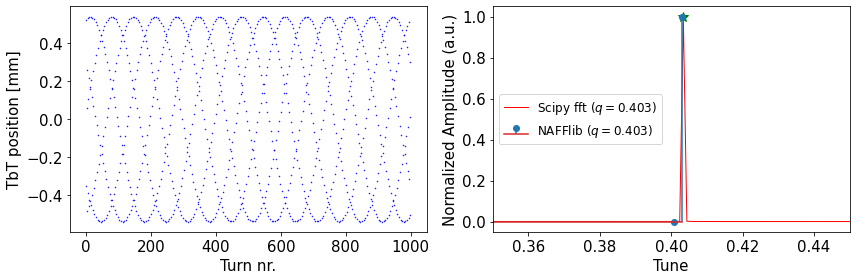

In [123]:
f,axs = plt.subplots(1,2,figsize=(12,4))
fontsize=15

ax = axs[0]
ax.set_xlabel('Turn nr.', fontsize=fontsize)
ax.set_ylabel('TbT position [mm]', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.plot(data2*1e3, '.', ms=1.0, c='blue')

ax = axs[1]
ax.set_xlabel('Tune', fontsize=fontsize)
ax.set_ylabel('Normalized Amplitude (a.u.)', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.plot(tunes, norm_ampls, '-', c='red', lw=1.0, label='Scipy fft ($q=%1.3f$)'%max_tunes[0])
ax.plot(max_tunes[0:1], max_ampls[0:1], '*', ms=10, color='green')
ax.stem(qs, abs(A/np.max(A)), label='NAFFlib ($q=%1.3f$)'%qs[0])
ax.legend(loc=0, fontsize=fontsize-3)
ax.set_xlim(0.35,0.45)

f.tight_layout()
plt.show()
